# [IA Frameworks](https://github.com/wikistat/AI-Frameworks) - Introduction to Deep Reinforcement Learning 

<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" width=400, style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# Part 1 : Deep Q-Network
The objectives of this noteboks are the following : 

* Implement DQN on a pacman-like game (gridworld)
* Implement D3QN on the same game
 
Source : [https://github.com/ageron/handson-ml](https://github.com/ageron/handson-ml) and https://github.com/breeko/Simple-Reinforcement-Learning-with-Tensorflow/blob/master/Part%202%20-%20Policy-based%20Agents%20with%20Keras.ipynb

# Import librairies

In [3]:
import copy
import numpy as np
import random
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures and animations
%matplotlib inline
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML


plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.initializers as ki
import tensorflow.keras.optimizers as ko
import tensorflow.keras.losses as klo
import tensorflow.keras.backend as K


# Gym Librairy
import gym
import pandas as pd


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=400):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

# DEEP Q Learning on *Pacman-Like* Game

We have seen how to learn an optimal policy on a Markov Decision Process. 

Let's now try to learn how to play a Video Game Like Pacman. 

We won't use directly Pacman here (Even if it's available on Gym environment (see below)). The Pacman game requires GPU to be trained and may need some try and parameter optimization to easily converged. 

Hence, we will start with and simpler environment which looks like Pacman : the [gridworld](https://github.com/awjuliani/DeepRL-Agents/blob/master/gridworld.py) environment.




### Grid World environment

We have a 5x5 blocs where blue, green and red squares. In the environment:
* the **agent** controls a *blue* square
* the goal is to navigate to the *green* squares (**reward** +1) 
* and avoiding the *red* squares (**reward** -1).

#### Observation

The observation is the image itself which is a 84x84x3 images.

#### Actions

Num | Action
--- | ---
0 | Go Up
1 | Go Down
2 | Go Left
3 | Go Right


#### Reward
Reward is 1 for every green square taken and -1 when a red square is taken

#### End epsiode
There are no condition limit for an episode to finish

We initiate the environment

<IPython.core.display.Javascript object>


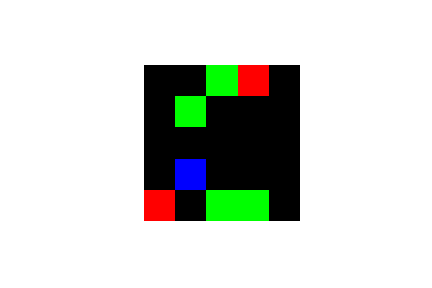

In [4]:
from gridworld import gameEnv
env = gameEnv(partial=False, size=5)

**Exercise**: Let's play a game manually to understand how it works. Fill the actions_list with step in order to win points according to the intialised environment.

<IPython.core.display.Javascript object>


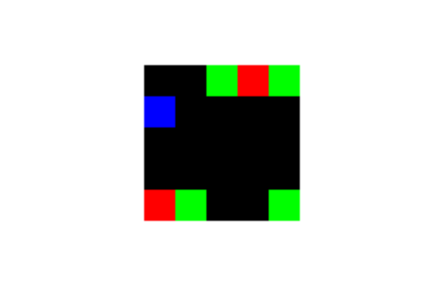

In [5]:
frames = []
cum_reward=0
actions_list=[1,3,3,0,0,0,2,2,2]
for step in actions_list:
    state, reward , end = env.step(step)
    frames.append(state)
    cum_reward+=reward
cum_reward
HTML(plot_animation(frames).to_html5_video())

### Experience Replay Buffer

To make DQNs work you need an **Experience Replay Buffer**. The basic idea is that by storing an agent’s experiences, and then randomly drawing batches of them to train the network, we can more robustly learn to perform well in the task. The Experience Replay buffer stores a fixed number of recent memories, and as new ones come in, old ones are removed. When the time comes to train, we simply draw a uniform batch of random memories from the buffer, and train our network with them. For our DQN, we will build a simple class that handles storing and retrieving memories.

In [136]:
class ExperienceReplay:
    def __init__(self, buffer_size=50000):
        """ Data structure used to hold game experiences """
        # Buffer will contain [state,action,reward,next_state,done]
        self.buffer = []
        self.buffer_size = buffer_size

    def add(self, experience):
        """ Adds list of experiences to the buffer """
        # Extend the stored experiences
        self.buffer.extend(experience)
        # Keep the last buffer_size number of experiences
        self.buffer = self.buffer[-self.buffer_size:]

    def sample(self, size):
        """ Returns a sample of experiences from the buffer """
        sample_idxs = np.random.randint(len(self.buffer), size=size)
        sample_output = [self.buffer[idx] for idx in sample_idxs]
        sample_output = np.reshape(sample_output, (size, -1))
        return sample_output

In [140]:
experience_replay = ExperienceReplay(buffer_size=10)
experience_replay.add(list(range(100)))
print(experience_replay.buffer)
sample = experience_replay.sample(5)
print(sample)

[90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[[93]
 [99]
 [98]
 [91]
 [97]]


### Architecture and loss of network


#### Q-Learning
Here are the Q-learning formula used above

$$target = R(s,a,s')+\gamma \max\limits_{a'}Q_k(s',a')$$
$$Q_{k+1}(s,a)\leftarrow(1-a)Q_k(s,a)+\alpha[target]$$

if the combinations of states and actions are too large, the memory and the computation requirement for Q will be too high.

#### Deep Q-learning

To address that, we switch to a deep network Q (DQN) to approximate Q(s, a). The learning algorithm is called Deep Q-learning. With the new approach, we generalize the approximation of the Q-value function rather than remembering the solutions.

$$target = R(s,a,s')+\gamma \max\limits_{a'}Q_k(s',a')$$
$$\theta_{k+1} \leftarrow \theta_k - \alpha\nabla_{\theta}\mathbb{E}_{s\sim'P(s'|s,a)} [(Q_{\theta}(s,a)-target(s'))^2]_{\theta=\theta_k} $$

We define below a convolutional network. 

**Exercise** Complete the code of the convolutional network below with the input and output shape in order to make it work with our problem.

In [8]:
class Qnetwork():
    def __init__(self):
        self.inputs = kl.Input(shape=#COMPLETE, name="main_input")

        self.model = kl.Conv2D(
            filters=32,
            kernel_size=[8, 8],
            strides=[4, 4],
            activation="relu",
            padding="valid",
            name="conv1")(self.inputs)
        self.model = kl.Conv2D(
            filters=64,
            kernel_size=[4, 4],
            strides=[2, 2],
            activation="relu",
            padding="valid",
            name="conv2")(self.model)
        self.model = kl.Conv2D(
            filters=64,
            kernel_size=[3, 3],
            strides=[1, 1],
            activation="relu",
            padding="valid",
            name="conv3")(self.model)
        self.model = kl.Conv2D(
            filters=512,
            kernel_size=[7, 7],
            strides=[1, 1],
            activation="relu",
            padding="valid",
            name="conv4")(self.model)

        self.model = kl.Flatten()(self.model)
        self.model = kl.Dense(256, activation="relu")(self.model)
        self.model = kl.Dense(#COMPLETE, activation = "linear")(self.model)
        self.model = km.Model(self.inputs, self.model)
        self.model.compile("adam", "mse")
        self.model.optimizer.lr = 0.0001

SyntaxError: invalid syntax (<ipython-input-8-77ed2f1993a8>, line 5)

In [10]:
# %load solutions/exercise_2_3.py
class Qnetwork():
    def __init__(self):
        self.inputs = kl.Input(shape=[84, 84, 3], name="main_input")

        self.model = kl.Conv2D(
            filters=32,
            kernel_size=[8, 8],
            strides=[4, 4],
            activation="relu",
            padding="valid",
            name="conv1")(self.inputs)
        self.model = kl.Conv2D(
            filters=64,
            kernel_size=[4, 4],
            strides=[2, 2],
            activation="relu",
            padding="valid",
            name="conv2")(self.model)
        self.model = kl.Conv2D(
            filters=64,
            kernel_size=[3, 3],
            strides=[1, 1],
            activation="relu",
            padding="valid",
            name="conv3")(self.model)
        self.model = kl.Conv2D(
            filters=512,
            kernel_size=[7, 7],
            strides=[1, 1],
            activation="relu",
            padding="valid",
            name="conv4")(self.model)

        self.model = kl.Flatten()(self.model)
        self.model = kl.Dense(256, activation="relu")(self.model)
        self.model = kl.Dense(4, activation = "linear")(self.model)
        self.model = km.Model(self.inputs, self.model)
        self.model.compile("adam", "mse")
        self.model.optimizer.lr = 0.0001

Init a model in order to display it's summary.

In [11]:
main_qn = Qnetwork()
main_qn.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 84, 84, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 20, 20, 32)        6176      
_________________________________________________________________
conv2 (Conv2D)               (None, 9, 9, 64)          32832     
_________________________________________________________________
conv3 (Conv2D)               (None, 7, 7, 64)          36928     
_________________________________________________________________
conv4 (Conv2D)               (None, 1, 1, 512)         1606144   
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328

### DQN Class

#### Separated Target network
Here is how the target is supposed to be computed in order to train or Deep-Q network.

$$target = R(s,a,s')+\gamma \max\limits_{a'}Q_k(s',a';\theta) $$


We build a deep network to learn the values of Q but its target values are changing as we know things better. As shown below, the target values for Q depends on Q itself, we are chasing a non-stationary target. So we use a different network to generate the target, that will be updated from time to time


$$target = R(s,a,s')+\gamma \max\limits_{a'}Q_k(s',a';\theta_{target}) $$


**Exercise**  Complete the class below to train a DQN network

1. Pay attention to all the parameters define in the init and make sure you understand its.
2. Look at the train function that allow to run the pseudo code described below.
3. Go inside all other function and complete the code where you'll find a TODO mark.


#### Pseudo Code
* while num_episode < self.num_episodes:

    1. Run one complete episode:
        * If less than *pre_train_episode* has been played:
            * Play randomly
        * Else
            * play randomly with probability *prob_random* (Exploration) else play with the *main_q* network (Exploitation).
        * Store the episode in the *ReplayBuffer*
    2. If more than *pre_train_episode* has been played
                * Decrease the probability of playing randomly (in order to use more Exploitation than Exploration (e-greedy policy).
                * Every 5 episodes played:
                    * Train the episode using episode from the *ReplayBuffer* and using the target build from the *target_q network*
                    * Update the *target_q* weight with *main_q* weight.

In [15]:
class DQN:
    def __init__(self):
        self.batch_size = 64  # How many experiences to use for each training step
        self.num_epochs = 20  # How many epochs to train
        self.update_freq = 5  # How often you update the network
        self.y = 0.99  # Discount factor
        self.prob_random_start = 0.6  # Starting chance of random action
        self.prob_random_end = 0.1  # Ending chance of random action
        self.annealing_steps = 1000.  # Steps of training to reduce from start_e -> end_e
        self.max_num_episodes = 10000  # How many episodes of game environment to train
        self.pre_train_episodes = 100  # Number of episodes of random actions
        self.max_num_step = 50  # Maximum allowed episode length
        self. goal = 15

        # Reset everything
        K.clear_session()

        #TODO: Setup both the main and the target network.
        

        #TODO Setup our experience replay
        self.experience_replay = ExperienceReplay()

    def update_target_graph(self):
        # TODO : This function will be called every  self.update_freq train step, in order to copy all the weight of the main Q network to the target Q network


    def run_one_episode(self, num_episode, prob_random):
        # Create an experience replay for the current episode
        episode_buffer = ExperienceReplay()

        # Get the game state from the environment
        state = env.reset()

        done = False  # Game is complete
        sum_rewards = 0  # Running sum of rewards in episode
        cur_step = 0  # Running sum of number of steps taken in episode

        while cur_step < self.max_num_step and not done:
            cur_step += 1
            
            # TODO while that we haven't reach the  self.pre_train_episodes number of pre train episod, the action for the given state is choosen randomly. 
            # WHen self.pre_train_episode is reached, choose randomly tha ction with a 'prob_random' probability else use the main Q network
            

            # TODO Use action and retrieve the next state, reward and done

            # Setup the episode to be stored in the episode buffer
            episode = np.array([[state], action, reward, [next_state], done])
            episode = episode.reshape(1, -1)

            # Store the experience in the episode buffer
            episode_buffer.add(episode)

            # Update the running rewards
            sum_rewards += reward

            # Update the state
            state = next_state

        return episode_buffer, sum_rewards, cur_step

    def train_one_step(self):
        # TODO  Sample a batch from the self.experience_replay class
        train_batch = self.experience_replay.sample(self.batch_size)

        # Separate the batch into its components
        train_state, train_action, train_reward, \
        train_next_state, train_done = train_batch.T

        # Convert the action array into an array of ints so they can be used for indexing
        train_action = train_action.astype(np.int)

        # Stack the train_state and train_next_state for learning
        train_state = np.vstack(train_state)
        train_next_state = np.vstack(train_next_state)

        #TODO Build the target in order to use them to build our network


        # Train the main model
        loss = self.main_qn.model.train_on_batch(train_state, target_q)
        return loss


    def train(self):

        # Make the networks equal
        self.update_target_graph()

        # We'll begin by acting complete randomly. As we gain experience and improve,
        # we will begin reducing the probability of acting randomly, and instead
        # take the actions that our Q network suggests
        prob_random = self.prob_random_start
        prob_random_drop = (self.prob_random_start - self.prob_random_end) / self.annealing_steps

        num_steps = []  # Tracks number of steps per episode
        rewards = []  # Tracks rewards per episode
        print_every = 50  # How often to print status
        losses = [0]  # Tracking training losses
        num_episode = 0

        while num_episode < self.max_num_episodes:

            episode_buffer, sum_rewards, cur_step = self.run_one_episode(num_episode, prob_random)

            if num_episode > self.pre_train_episodes:
                # Training the network

                if prob_random > self.prob_random_end:
                    # Drop the probability of a random action
                    prob_random -= prob_random_drop

                if num_episode % self.update_freq == 0:
                    for num_epoch in range(self.num_epochs):
                        loss = self.train_one_step()
                        losses.append(loss)

                    # Update the target model with values from the main model
                    self.update_target_graph()

            # Increment the episode
            num_episode += 1

            self.experience_replay.add(episode_buffer.buffer)
            num_steps.append(cur_step)
            rewards.append(sum_rewards)

            if num_episode % print_every == 0:
                # Print progress
                mean_loss = np.mean(losses[-(print_every * self.num_epochs):])

                print("Num episode: {} Mean reward: {:0.4f} Prob random: {:0.4f}, Loss: {:0.04f}".format(
                    num_episode, np.mean(rewards[-print_every:]), prob_random, mean_loss))
                if np.mean(rewards[-print_every:]) >= self.goal:
                    print("Training complete!")
                    break



IndentationError: expected an indented block (<ipython-input-15-12395a30913c>, line 28)

In [19]:
# %load solutions/exercise_2_4.py
class DQN:
    def __init__(self):
        self.batch_size = 64  # How many experiences to use for each training step
        self.num_epochs = 20  # How many epochs to train
        self.train_frequency = 5  # How often you update the network
        self.y = 0.99  # Discount factor
        self.prob_random_start = 0.6  # Starting chance of random action
        self.prob_random_end = 0.1  # Ending chance of random action
        self.annealing_steps = 1000.  # Steps of training to reduce from start_e -> end_e
        self.max_num_episodes = 10000  # How many episodes of game environment to train
        self.min_pre_train_episodes = 100  # Number of episodes of random actions
        self.max_num_step = 50  # Maximum allowed episode length
        self. goal = 15

        # Reset everything
        K.clear_session()

        # Setup our Q-networks
        self.main_qn = Qnetwork()
        self.target_qn = Qnetwork()

        # Setup our experience replay
        self.experience_replay = ExperienceReplay()

    def update_target_graph(self):
        updated_weights = np.array(self.main_qn.model.get_weights())
        self.target_qn.model.set_weights(updated_weights)


    def run_one_episode(self, num_episode, prob_random):
        # Create an experience replay for the current episode
        episode_buffer = ExperienceReplay()

        # Get the game state from the environment
        state = env.reset()

        done = False  # Game is complete
        sum_rewards = 0  # Running sum of rewards in episode
        cur_step = 0  # Running sum of number of steps taken in episode

        while cur_step < self.max_num_step and not done:
            cur_step += 1
            if np.random.rand() < prob_random or \
                    num_episode < self.min_pre_train_episodes:
                # Act randomly based on prob_random or if we
                # have not accumulated enough pre_train episodes
                action = np.random.randint(env.actions)
            else:
                # Decide what action to take from the Q network
                action = np.argmax(self.main_qn.model.predict(np.array([state])))

            # Take the action and retrieve the next state, reward and done
            next_state, reward, done = env.step(action)

            # Setup the episode to be stored in the episode buffer
            episode = np.array([[state], action, reward, [next_state], done])
            episode = episode.reshape(1, -1)

            # Store the experience in the episode buffer
            episode_buffer.add(episode)

            # Update the running rewards
            sum_rewards += reward

            # Update the state
            state = next_state

        return episode_buffer, sum_rewards, cur_step

    def train_one_step(self):
        # Train batch is [[state,action,reward,next_state,done],...]
        train_batch = self.experience_replay.sample(self.batch_size)

        # Separate the batch into its components
        train_state, train_action, train_reward, \
        train_next_state, train_done = train_batch.T

        # Convert the action array into an array of ints so they can be used for indexing
        train_action = train_action.astype(np.int)

        # Stack the train_state and train_next_state for learning
        train_state = np.vstack(train_state)
        train_next_state = np.vstack(train_next_state)

        # Our predictions (actions to take) from the main Q network
        target_q = self.main_qn.model.predict(train_state)

        # Tells us whether game over or not
        # We will multiply our rewards by this value
        # to ensure we don't train on the last move
        train_gameover = train_done == 0

        # Q value of the next state based on action
        target_q_next_state = self.target_qn.model.predict(train_next_state)
        train_next_state_values = np.max(target_q_next_state[range(self.batch_size)], axis=1)

        # Reward from the action chosen in the train batch
        actual_reward = train_reward + (self.y * train_next_state_values * train_gameover)
        target_q[range(self.batch_size), train_action] = actual_reward

        # Train the main model
        loss = self.main_qn.model.train_on_batch(train_state, target_q)
        return loss


    def train(self):

        # Make the networks equal
        self.update_target_graph()

        # We'll begin by acting complete randomly. As we gain experience and improve,
        # we will begin reducing the probability of acting randomly, and instead
        # take the actions that our Q network suggests
        prob_random = self.prob_random_start
        prob_random_drop = (self.prob_random_start - self.prob_random_end) / self.annealing_steps

        num_steps = []  # Tracks number of steps per episode
        rewards = []  # Tracks rewards per episode
        print_every = 50  # How often to print status
        losses = [0]  # Tracking training losses
        num_episode = 0

        while num_episode < self.max_num_episodes:

            episode_buffer, sum_rewards, cur_step = self.run_one_episode(num_episode, prob_random)
            self.experience_replay.add(episode_buffer.buffer)

            if num_episode > self.min_pre_train_episodes:
                # Training the network

                if prob_random > self.prob_random_end:
                    # Drop the probability of a random action
                    prob_random -= prob_random_drop

                if num_episode % self.train_frequency == 0:
                    for num_epoch in range(self.num_epochs):
                        loss = self.train_one_step()
                        losses.append(loss)

                    # Update the target model with values from the main model
                    self.update_target_graph()

            # Increment the episode
            num_episode += 1
            num_steps.append(cur_step)
            rewards.append(sum_rewards)

            if num_episode % print_every == 0:
                # Print progress
                mean_loss = np.mean(losses[-(print_every * self.num_epochs):])

                print("Num episode: {} Mean reward: {:0.4f} Prob random: {:0.4f}, Loss: {:0.04f}".format(
                    num_episode, np.mean(rewards[-print_every:]), prob_random, mean_loss))
                if np.mean(rewards[-print_every:]) >= self.goal:
                    print("Training complete!")
                    break



Train the model

In [20]:
dqn = DQN()
dqn.train()

Num episode: 50 Mean reward: 1.6400 Prob random: 0.6000, Loss: 0.0000
Num episode: 100 Mean reward: 2.0400 Prob random: 0.6000, Loss: 0.0000
Num episode: 150 Mean reward: 1.4200 Prob random: 0.5755, Loss: 0.7006
Num episode: 200 Mean reward: 0.9000 Prob random: 0.5505, Loss: 0.3659
Num episode: 250 Mean reward: 1.7800 Prob random: 0.5255, Loss: 0.2573
Num episode: 300 Mean reward: 2.1400 Prob random: 0.5005, Loss: 0.2046
Num episode: 350 Mean reward: 2.8200 Prob random: 0.4755, Loss: 0.1739
Num episode: 400 Mean reward: 2.1600 Prob random: 0.4505, Loss: 0.0555
Num episode: 450 Mean reward: 2.6200 Prob random: 0.4255, Loss: 0.0539
Num episode: 500 Mean reward: 4.7800 Prob random: 0.4005, Loss: 0.0548
Num episode: 550 Mean reward: 3.9200 Prob random: 0.3755, Loss: 0.0558
Num episode: 600 Mean reward: 4.8400 Prob random: 0.3505, Loss: 0.0557
Num episode: 650 Mean reward: 5.7000 Prob random: 0.3255, Loss: 0.0540
Num episode: 700 Mean reward: 5.5800 Prob random: 0.3005, Loss: 0.0542
Num epi

**Exercise** Play a pacman game and display the result of a game in video.

In [ ]:
# %load solutions/exercise_2_5.py

### DQN Improvement

DQN has  been improved recently by using two different tricks (among others):

* Dueling
* Double DQN

Implement these two solutions.

#### Dueling

See the dueling architecture : 


In order to explain the reasoning behind the architecture changes that Dueling DQN makes, we need to first explain some a few additional reinforcement learning terms. The Q-values that we have been discussing so far correspond to how good it is to take a certain action given a certain state. This can be written as Q(s,a). This action given state can actually be decomposed into two more fundamental notions of value. The first is the value function V(s), which says simple how good it is to be in any given state. The second is the advantage function A(a), which tells how much better taking a certain action would be compared to the others. We can then think of Q as being the combination of V and A. More formally:
$$Q(s,a) =V(s) + A(a)$$
The goal of Dueling DQN is to have a network that separately computes the advantage and value functions, and combines them back into a single Q-function only at the final layer. It may seem somewhat pointless to do this at first glance. Why decompose a function that we will just put back together? The key to realizing the benefit is to appreciate that our reinforcement learning agent may not need to care about both value and advantage at any given time. For example: imagine sitting outside in a park watching the sunset. It is beautiful, and highly rewarding to be sitting there. No action needs to be taken, and it doesn’t really make sense to think of the value of sitting there as being conditioned on anything beyond the environmental state you are in. We can achieve more robust estimates of state value by decoupling it from the necessity of being attached to specific actions.

In [ ]:
# %load solutions/exercise_2_6.py

In [ ]:
main_qn = Qnetwork()
main_qn.model.summary()

#### Double DQN


This lead to often overestimates the Q-values of the potential actions to take in a given state. While this would be fine if all actions were always overestimates equally, there was reason to believe this wasn’t the case. You can easily imagine that if certain suboptimal actions regularly were given higher Q-values than optimal actions, the agent would have a hard time ever learning the ideal policy. In order to correct for this, the authors of DDQN paper propose a simple trick: instead of taking the max over Q-values when computing the target-Q value for our training step, we use our primary network to chose an action, and our target network to generate the target Q-value for that action. By decoupling the action choice from the target Q-value generation, we are able to substantially reduce the overestimation, and train faster and more reliably. Below is the new DDQN equation for updating the target value.


$$target = R(s,a,s')+\gamma Q_k(s',argmax_aQ(s',a;\theta);\theta_{target}) $$



In [ ]:
# %load solutions/exercise_2_7.py

In [ ]:
dqn = DQN()
dqn.train()

## Real Pacman!

### Creating the MsPacman environment

In [124]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

(210, 160, 3)

In [83]:
env.action_space

Discrete(9)

### Preprocessing

Preprocessing the images is optional but greatly speeds up training.

In [ ]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)/128

img = preprocess_observation(obs)
img.shape

Note: the `preprocess_observation()` function is slightly different from the one in the book: instead of representing pixels as 64-bit floats from -1.0 to 1.0, it represents them as signed bytes (from -128 to 127). The benefit is that the replay memory will take up roughly 8 times less RAM (about 6.5 GB instead of 52 GB). The reduced precision has no visible impact on training.

In [ ]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()